# Notebook 13: Using Deep Learning to Study SUSY with Pytorch

## Learning Goals
The goal of this notebook is to introduce the powerful PyTorch framework for building neural networks and use it to analyze the SUSY dataset. After this notebook, the reader should understand the mechanics of PyTorch and how to construct DNNs using this package. In addition, the reader is encouraged to explore the GPU backend available in Pytorch on this dataset.

## Overview
In this notebook, we use Deep Neural Networks to classify the supersymmetry dataset, first introduced by Baldi et al. in [Nature Communication (2015)](https://www.nature.com/articles/ncomms5308). The SUSY data set consists of 5,000,000 Monte-Carlo samples of supersymmetric and non-supersymmetric collisions with $18$ features. The signal process is the production of electrically-charged supersymmetric particles which decay to $W$ bosons and an electrically-neutral supersymmetric particle that is invisible to the detector.

The first $8$ features are "raw" kinematic features that can be directly measured from collisions. The final $10$ features are "hand constructed" features that have been chosen using physical knowledge and are known to be important in distinguishing supersymmetric and non-supersymmetric collision events. More specifically, they are given by the column names below.

In this notebook, we study this dataset using Pytorch.

In [1]:
from __future__ import print_function, division
import os,sys
import numpy as np
import torch # pytorch package, allows using GPUs
# fix seed
seed=17
np.random.seed(seed)
torch.manual_seed(seed)

## Structure of the Procedure

Constructing a Deep Neural Network to solve ML problems is a multiple-stage process. Quite generally, one can identify the key steps as follows:

* ***step 1:*** Load and process the data
* ***step 2:*** Define the model and its architecture
* ***step 3:*** Choose the optimizer and the cost function
* ***step 4:*** Train the model 
* ***step 5:*** Evaluate the model performance on the *unseen* test data
* ***step 6:*** Modify the hyperparameters to optimize performance for the specific data set

Below, we sometimes combine some of these steps together for convenience.

Notice that we take a rather different approach, compared to the simpler MNIST Keras notebook. We first define a set of classes and functions and run the actual computation only in the very end.

### Step 1: Load and Process the SUSY Dataset

The supersymmetry dataset can be downloaded from the UCI Machine Learning repository on [https://archive.ics.uci.edu/ml/machine-learning-databases/00279/SUSY.csv.gz](https://archive.ics.uci.edu/ml/machine-learning-databases/00279/SUSY.csv.gz). The dataset is quite large. Download the dataset and unzip it in a directory.

Loading data in Pytroch is done by creating a user-defined a class, which we name `SUSY_Dataset`, and is a child of the `torch.utils.data.Dataset` class. This ensures that all necessary attributes required for the processing of the data during the training and test stages are easily inherited. The `__init__` method of our custom data class should contain the usual code for loading the data, which is problem-specific, and has been discussed for the SUSY data set in Notebook 5. More importantly, the user-defined data class must override the `__len__` and `__getitem__` methods of the parent `DataSet` class. The former returns the size of the data set, while the latter allows the user to access a particular data point from the set by specifying its index.

In [2]:
from torchvision import datasets # load data

class SUSY_Dataset(torch.utils.data.Dataset):
    """SUSY pytorch dataset."""

    def __init__(self, data_file, root_dir, dataset_size, train=True, transform=None, high_level_feats=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            train (bool, optional): If set to `True` load training data.
            transform (callable, optional): Optional transform to be applied on a sample.
            high_level_festures (bool, optional): If set to `True`, working with high-level features only. 
                                        If set to `False`, working with low-level features only.
                                        Default is `None`: working with all features
        """

        import pandas as pd

        features=['SUSY','lepton 1 pT', 'lepton 1 eta', 'lepton 1 phi', 'lepton 2 pT', 'lepton 2 eta', 'lepton 2 phi', 
                'missing energy magnitude', 'missing energy phi', 'MET_rel', 'axial MET', 'M_R', 'M_TR_2', 'R', 'MT2', 
                'S_R', 'M_Delta_R', 'dPhi_r_b', 'cos(theta_r1)']

        low_features=['lepton 1 pT', 'lepton 1 eta', 'lepton 1 phi', 'lepton 2 pT', 'lepton 2 eta', 'lepton 2 phi', 
                'missing energy magnitude', 'missing energy phi']

        high_features=['MET_rel', 'axial MET', 'M_R', 'M_TR_2', 'R', 'MT2','S_R', 'M_Delta_R', 'dPhi_r_b', 'cos(theta_r1)']


        #Number of datapoints to work with
        df = pd.read_csv(root_dir+data_file, header=None,nrows=dataset_size,engine='python')
        df.columns=features
        Y = df['SUSY']
        X = df[[col for col in df.columns if col!="SUSY"]]

        # set training and test data size
        train_size=int(0.8*dataset_size)
        self.train=train

        if self.train:
            X=X[:train_size]
            Y=Y[:train_size]
            print("Training on {} examples".format(train_size))
        else:
            X=X[train_size:]
            Y=Y[train_size:]
            print("Testing on {} examples".format(dataset_size-train_size))


        self.root_dir = root_dir
        self.transform = transform

        # make datasets using only the 8 low-level features and 10 high-level features
        if high_level_feats is None:
            self.data=(X.values.astype(np.float32),Y.values.astype(int))
            print("Using both high and low level features")
        elif high_level_feats is True:
            self.data=(X[high_features].values.astype(np.float32),Y.values.astype(int))
            print("Using both high-level features only.")
        elif high_level_feats is False:
            self.data=(X[low_features].values.astype(np.float32),Y.values.astype(int))
            print("Using both low-level features only.")


    # override __len__ and __getitem__ of the Dataset() class

    def __len__(self):
        return len(self.data[1])

    def __getitem__(self, idx):

        sample=(self.data[0][idx,...],self.data[1][idx])

        if self.transform:
            sample=self.transform(sample)

        return sample

Last, we define a helper function `load_data()` that accepts as a required argument the set of parameters `args`, and returns two generators: `test_loader` and `train_loader` which readily return mini-batches.

In [3]:
def load_data(args):

    data_file='SUSY.csv'
    root_dir=os.path.expanduser('~')+'/Desktop/Fall2019/HW895/PY895/'

    kwargs = {} # CUDA arguments, if enabled
    # load and noralise train and test data
    train_loader = torch.utils.data.DataLoader(
        SUSY_Dataset(data_file,root_dir,args.dataset_size,train=True,high_level_feats=args.high_level_feats),
        batch_size=args.batch_size, shuffle=True, **kwargs)

    test_loader = torch.utils.data.DataLoader(
        SUSY_Dataset(data_file,root_dir,args.dataset_size,train=False,high_level_feats=args.high_level_feats),
        batch_size=args.test_batch_size, shuffle=True, **kwargs)

    return train_loader, test_loader

### Step 2: Define the Neural Net and its Architecture

To construct neural networks with Pytorch, we make another class called `model` as a child of Pytorch's `nn.Module` class. The `model` class initializes the types of layers needed for the deep neural net in its `__init__` method, while the DNN is assembled in a function method called `forward`, which accepts an `autograd.Variable` object and returns the output layer. Using this convention Pytorch will automatically recognize the structure of the DNN, and the `autograd` module will pull the gradients forward and backward using backprop.

Our code below is constructed in such a way that one can choose whether to use the high-level and low-level features separately and altogether. This choice determines the size of the fully-connected input layer `fc1`. Therefore the `__init__` method accepts the optional argument `high_level_feats`. 

In [4]:
import torch.nn as nn # construct NN

class model(nn.Module):
    def __init__(self,high_level_feats=None):
        # inherit attributes and methods of nn.Module
        super(model, self).__init__()

        # an affine operation: y = Wx + b
        if high_level_feats is None:
            self.fc1 = nn.Linear(18, 200) # all features
        elif high_level_feats:
            self.fc1 = nn.Linear(10, 200) # low-level only
        else:
            self.fc1 = nn.Linear(8, 200) # high-level only


        self.batchnorm1=nn.BatchNorm1d(200, eps=1e-05, momentum=0.1)
        self.batchnorm2=nn.BatchNorm1d(100, eps=1e-05, momentum=0.1)
        
        self.batchnorm3=nn.BatchNorm1d(100, eps=1e-05, momentum=0.2)
        
        self.fc2 = nn.Linear(200, 150) # see forward function for dimensions
        self.fcnew = nn.Linear(150, 100)
        self.fc3 = nn.Linear(100, 2)

    def forward(self, x):
        '''Defines the feed-forward function for the NN.

        A backward function is automatically defined using `torch.autograd`

        Parameters
        ----------
        x : autograd.Tensor
            input data

        Returns
        -------
        autograd.Tensor
            output layer of NN

        '''

        # apply rectified linear unit
        x = F.relu(self.fc1(x))
        # apply dropout
        x=self.batchnorm1(x)
        #x = F.dropout(x, training=self.training)


        # apply rectified linear unit
        x = F.leaky_relu(self.fc2(x))
        # apply dropout
        #x=self.batchnorm2(x)
        x = F.dropout(x, training=self.training)

        x = F.leaky_relu(self.fcnew(x))
        x = self.batchnorm3(x)
        
        # apply affine operation fc2
        x = self.fc3(x)
        # soft-max layer
        x = F.log_softmax(x,dim=1)

        return x

### Steps 3+4+5: Choose the Optimizer and the Cost Function. Train and Evaluate the Model

Next, we define the function `evaluate_model`. The first argument, `args`, contains all hyperparameters needed for the DNN (see below). The second and third arguments are the `train_loader` and the `test_loader` objects, returned by the function `load_data()` we defined in Step 1 above. The `evaluate_model` function returns the final `test_loss` and `test_accuracy` of the model.

First, we initialize a `model` and call the object `DNN`. In order to define the loss function and the optimizer, we use modules `torch.nn.functional` (imported here as `F`) and `torch.optim`. As a loss function we choose the negative log-likelihood, and stored is under the variable `criterion`. As usual, we can choose any from a variety of different SGD-based optimizers, but we focus on the traditional SGD.

Next, we define two functions: `train()` and `test()`. They are called at the end of `evaluate_model` where we loop over the training epochs to train and test our model. 

The `train` function accepts an integer called `epoch`, which is only used to print the training data. We first set the `DNN` in a train mode using the `train()` method inherited from `nn.Module`. Then we loop over the mini-batches in `train_loader`. We cast the data as pytorch `Variable`, re-set the `optimizer`, perform the forward step by calling the `DNN` model on the `data` and computing the `loss`. The backprop algorithm is then easily done using the `backward()` method of the loss function `criterion`. We use `optimizer.step` to update the weights of the `DNN`. Last print the performance for every minibatch. `train` returns the loss on the data.

The `test` function is similar to `train` but its purpose is to test the performance of a trained model. Once we set the `DNN` model in `eval()` mode, the following steps are similar to those in `train`. We then compute the `test_loss` and the number of `correct` predictions, print the results and return them.  

In [5]:
import torch.nn.functional as F # implements forward and backward definitions of an autograd operation
import torch.optim as optim # different update rules such as SGD, Nesterov-SGD, Adam, RMSProp, etc

def evaluate_model(args,train_loader,test_loader):

    # create model
    DNN = model(high_level_feats=args.high_level_feats)
    # negative log-likelihood (nll) loss for training: takes class labels NOT one-hot vectors!
    criterion = F.nll_loss
    # define SGD optimizer
    optimizer = optim.SGD(DNN.parameters(), lr=args.lr, momentum=args.momentum)
    #optimizer = optim.Adam(DNN.parameters(), lr=0.001, betas=(0.9, 0.999))


    ################################################

    def train(epoch):
        '''Trains a NN using minibatches.

        Parameters
        ----------
        epoch : int
            Training epoch number.

        '''

        # set model to training mode (affects Dropout and BatchNorm)
        DNN.train()
        # loop over training data
        for batch_idx, (data, label) in enumerate(train_loader):
            # zero gradient buffers
            optimizer.zero_grad()
            # convert labels to continuous "longs"
            label = label.type(torch.LongTensor)
            # compute output of final layer: forward step
            output = DNN(data)
            # compute loss
            loss = criterion(output, label)
            # run backprop: backward step
            loss.backward()
            # update weigths of NN
            optimizer.step()
            
            # print loss at current epoch
            if batch_idx % args.log_interval == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch, batch_idx * len(data), len(train_loader.dataset),
                    100. * batch_idx / len(train_loader), loss.item() ))
            

        return loss.item()

    ################################################

    def test():
        '''Tests NN performance.

        '''

        # evaluate model
        DNN.eval()

        test_loss = 0 # loss function on test data
        correct = 0 # number of correct predictions
        # loop over test data
        for data, label in test_loader:
            # compute model prediction softmax probability
            output = DNN(data)
            # compute test loss
            label = label.type(torch.LongTensor)
            test_loss += criterion(output, label, size_average=False).item() # sum up batch loss
            # find most likely prediction
            pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
            # update number of correct predictions
            correct += pred.eq(label.data.view_as(pred)).cpu().sum().item()

        # print test loss
        test_loss /= len(test_loader.dataset)
        
        print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.3f}%)\n'.format(
            test_loss, correct, len(test_loader.dataset),
            100. * correct / len(test_loader.dataset)))
        

        return test_loss, correct / len(test_loader.dataset)


    ################################################


    train_loss=np.zeros((args.epochs,))
    test_loss=np.zeros_like(train_loss)
    test_accuracy=np.zeros_like(train_loss)

    epochs=range(1, args.epochs + 1)
    for epoch in epochs:

        train_loss[epoch-1] = train(epoch)
        test_loss[epoch-1], test_accuracy[epoch-1] = test()



    return test_loss[-1], test_accuracy[-1]

### Step 6: Modify the Hyperparameters to Optimize Performance of the Model

To study the performance of the model for a variety of different `data_set_sizes` and `learning_rates`, we do a grid search. 

Let us define a function `grid_search`, which accepts the `args` variable containing all hyper-parameters needed for the problem. After choosing logarithmically-spaced `data_set_sizes` and `learning_rates`, we first loop over all `data_set_sizes`, update the `args` variable, and call the `load_data` function. We then loop once again over all `learning_rates`, update `args` and call `evaluate_model`.

In [6]:
def grid_search(args):


    # perform grid search over learnign rate and number of hidden neurons
    dataset_sizes=[1000000] #np.logspace(2,5,4).astype('int')
    learning_rates=np.logspace(-2,0,3)

    # pre-alocate data
    test_loss=np.zeros((len(dataset_sizes),len(learning_rates)),dtype=np.float64)
    test_accuracy=np.zeros_like(test_loss)

    # do grid search
    for i, dataset_size in enumerate(dataset_sizes):
        # upate data set size parameters
        args.dataset_size=dataset_size
        args.batch_size=int(0.001*dataset_size)

        # load data
        train_loader, test_loader = load_data(args)

        for j, lr in enumerate(learning_rates):
            # update learning rate
            args.lr=lr

            print("\n training DNN with %5d data points and SGD lr=%0.6f. \n" %(dataset_size,lr) )

            test_loss[i,j],test_accuracy[i,j] = evaluate_model(args,train_loader,test_loader)


    plot_data(learning_rates,dataset_sizes,test_accuracy)

Last, we use the function `plot_data`, defined below, to plot the results. 

In [7]:
import matplotlib.pyplot as plt

def plot_data(x,y,data):

    # plot results
    fontsize=16


    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(data, interpolation='nearest', vmin=0, vmax=1)
    
    cbar=fig.colorbar(cax)
    cbar.ax.set_ylabel('accuracy (%)',rotation=90,fontsize=fontsize)
    cbar.set_ticks([0,.2,.4,0.6,0.8,1.0])
    cbar.set_ticklabels(['0%','20%','40%','60%','80%','100%'])

    # put text on matrix elements
    for i, x_val in enumerate(np.arange(len(x))):
        for j, y_val in enumerate(np.arange(len(y))):
            c = "${0:.1f}\\%$".format( 100*data[j,i])  
            ax.text(x_val, y_val, c, va='center', ha='center')

    # convert axis vaues to to string labels
    x=[str(i) for i in x]
    y=[str(i) for i in y]


    ax.set_xticklabels(['']+x)
    ax.set_yticklabels(['']+y)

    ax.set_xlabel('$\\mathrm{learning\\ rate}$',fontsize=fontsize)
    ax.set_ylabel('$\\mathrm{hidden\\ neurons}$',fontsize=fontsize)

    plt.tight_layout()

    plt.show()

## Run Code

As we mentioned in the beginning of the notebook, all functions and classes discussed above only specify the procedure but do not actually perform any computations. This allows us to re-use them for different problems. 

Actually running the training and testing for every point in the grid search is done below. The `argparse` class allows us to conveniently keep track of all hyperparameters, stored in the variable `args` which enters most of the functions we defined above. 

To run the simulation, we call the function `grid_search`. 

## Exercises

* One of the advantages of Pytorch is that it allows to automatically use the CUDA library for fast performance on GPU's. For the sake of clarity, we have omitted this in the above notebook. Go online to check how to put the CUDA commands back into the code above. _Hint:_ study the [Pytorch MNIST tutorial](https://github.com/pytorch/examples/blob/master/mnist/main.py) to see how this works in practice.


Training on 800000 examples
Using both high and low level features
Testing on 200000 examples
Using both high and low level features

 training DNN with 1000000 data points and SGD lr=0.010000. 

Train Epoch: 1 [0/800000 (0%)]	Loss: 0.749476
Train Epoch: 1 [10000/800000 (1%)]	Loss: 0.651542
Train Epoch: 1 [20000/800000 (2%)]	Loss: 0.624470
Train Epoch: 1 [30000/800000 (4%)]	Loss: 0.585123
Train Epoch: 1 [40000/800000 (5%)]	Loss: 0.576296
Train Epoch: 1 [50000/800000 (6%)]	Loss: 0.566353
Train Epoch: 1 [60000/800000 (8%)]	Loss: 0.544867
Train Epoch: 1 [70000/800000 (9%)]	Loss: 0.540182
Train Epoch: 1 [80000/800000 (10%)]	Loss: 0.532096
Train Epoch: 1 [90000/800000 (11%)]	Loss: 0.541500
Train Epoch: 1 [100000/800000 (12%)]	Loss: 0.521525
Train Epoch: 1 [110000/800000 (14%)]	Loss: 0.504770
Train Epoch: 1 [120000/800000 (15%)]	Loss: 0.519058
Train Epoch: 1 [130000/800000 (16%)]	Loss: 0.521096
Train Epoch: 1 [140000/800000 (18%)]	Loss: 0.486106
Train Epoch: 1 [150000/800000 (19%)]	Loss: 0.5

C:\Users\chris\Miniconda3\lib\site-packages\torch\nn\_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Average loss: 0.4405, Accuracy: 159493/200000 (79.746%)

Train Epoch: 2 [0/800000 (0%)]	Loss: 0.447729
Train Epoch: 2 [10000/800000 (1%)]	Loss: 0.459586
Train Epoch: 2 [20000/800000 (2%)]	Loss: 0.480497
Train Epoch: 2 [30000/800000 (4%)]	Loss: 0.477133
Train Epoch: 2 [40000/800000 (5%)]	Loss: 0.447184
Train Epoch: 2 [50000/800000 (6%)]	Loss: 0.440492
Train Epoch: 2 [60000/800000 (8%)]	Loss: 0.440717
Train Epoch: 2 [70000/800000 (9%)]	Loss: 0.485780
Train Epoch: 2 [80000/800000 (10%)]	Loss: 0.452568
Train Epoch: 2 [90000/800000 (11%)]	Loss: 0.467580
Train Epoch: 2 [100000/800000 (12%)]	Loss: 0.459067
Train Epoch: 2 [110000/800000 (14%)]	Loss: 0.429934
Train Epoch: 2 [120000/800000 (15%)]	Loss: 0.446246
Train Epoch: 2 [130000/800000 (16%)]	Loss: 0.472695
Train Epoch: 2 [140000/800000 (18%)]	Loss: 0.430730
Train Epoch: 2 [150000/800000 (19%)]	Loss: 0.448160
Train Epoch: 2 [160000/800000 (20%)]	Loss: 0.464922
Train Epoch: 2 [170000/800000 (21%)]	Loss: 0.428590
Train Epoch: 2 [18

Train Epoch: 3 [750000/800000 (94%)]	Loss: 0.460277
Train Epoch: 3 [760000/800000 (95%)]	Loss: 0.447900
Train Epoch: 3 [770000/800000 (96%)]	Loss: 0.464870
Train Epoch: 3 [780000/800000 (98%)]	Loss: 0.389113
Train Epoch: 3 [790000/800000 (99%)]	Loss: 0.417779

Test set: Average loss: 0.4343, Accuracy: 160022/200000 (80.011%)

Train Epoch: 4 [0/800000 (0%)]	Loss: 0.427865
Train Epoch: 4 [10000/800000 (1%)]	Loss: 0.392353
Train Epoch: 4 [20000/800000 (2%)]	Loss: 0.458867
Train Epoch: 4 [30000/800000 (4%)]	Loss: 0.440520
Train Epoch: 4 [40000/800000 (5%)]	Loss: 0.440585
Train Epoch: 4 [50000/800000 (6%)]	Loss: 0.436685
Train Epoch: 4 [60000/800000 (8%)]	Loss: 0.429186
Train Epoch: 4 [70000/800000 (9%)]	Loss: 0.436667
Train Epoch: 4 [80000/800000 (10%)]	Loss: 0.437755
Train Epoch: 4 [90000/800000 (11%)]	Loss: 0.425865
Train Epoch: 4 [100000/800000 (12%)]	Loss: 0.411264
Train Epoch: 4 [110000/800000 (14%)]	Loss: 0.457446
Train Epoch: 4 [120000/800000 (15%)]	Loss: 0.453251
Train Epoch: 4 [13

Train Epoch: 5 [700000/800000 (88%)]	Loss: 0.445335
Train Epoch: 5 [710000/800000 (89%)]	Loss: 0.445318
Train Epoch: 5 [720000/800000 (90%)]	Loss: 0.448385
Train Epoch: 5 [730000/800000 (91%)]	Loss: 0.443102
Train Epoch: 5 [740000/800000 (92%)]	Loss: 0.436270
Train Epoch: 5 [750000/800000 (94%)]	Loss: 0.438048
Train Epoch: 5 [760000/800000 (95%)]	Loss: 0.432501
Train Epoch: 5 [770000/800000 (96%)]	Loss: 0.427241
Train Epoch: 5 [780000/800000 (98%)]	Loss: 0.449286
Train Epoch: 5 [790000/800000 (99%)]	Loss: 0.423427

Test set: Average loss: 0.4322, Accuracy: 160218/200000 (80.109%)

Train Epoch: 6 [0/800000 (0%)]	Loss: 0.449033
Train Epoch: 6 [10000/800000 (1%)]	Loss: 0.415693
Train Epoch: 6 [20000/800000 (2%)]	Loss: 0.435183
Train Epoch: 6 [30000/800000 (4%)]	Loss: 0.396516
Train Epoch: 6 [40000/800000 (5%)]	Loss: 0.442214
Train Epoch: 6 [50000/800000 (6%)]	Loss: 0.459852
Train Epoch: 6 [60000/800000 (8%)]	Loss: 0.424269
Train Epoch: 6 [70000/800000 (9%)]	Loss: 0.432845
Train Epoch: 6 [

Train Epoch: 7 [650000/800000 (81%)]	Loss: 0.423356
Train Epoch: 7 [660000/800000 (82%)]	Loss: 0.440262
Train Epoch: 7 [670000/800000 (84%)]	Loss: 0.447176
Train Epoch: 7 [680000/800000 (85%)]	Loss: 0.430963
Train Epoch: 7 [690000/800000 (86%)]	Loss: 0.422813
Train Epoch: 7 [700000/800000 (88%)]	Loss: 0.421584
Train Epoch: 7 [710000/800000 (89%)]	Loss: 0.433792
Train Epoch: 7 [720000/800000 (90%)]	Loss: 0.424263
Train Epoch: 7 [730000/800000 (91%)]	Loss: 0.446119
Train Epoch: 7 [740000/800000 (92%)]	Loss: 0.428667
Train Epoch: 7 [750000/800000 (94%)]	Loss: 0.417454
Train Epoch: 7 [760000/800000 (95%)]	Loss: 0.409347
Train Epoch: 7 [770000/800000 (96%)]	Loss: 0.443842
Train Epoch: 7 [780000/800000 (98%)]	Loss: 0.441166
Train Epoch: 7 [790000/800000 (99%)]	Loss: 0.460273

Test set: Average loss: 0.4315, Accuracy: 160347/200000 (80.174%)

Train Epoch: 8 [0/800000 (0%)]	Loss: 0.456280
Train Epoch: 8 [10000/800000 (1%)]	Loss: 0.437419
Train Epoch: 8 [20000/800000 (2%)]	Loss: 0.429312
Train 

Train Epoch: 9 [600000/800000 (75%)]	Loss: 0.443367
Train Epoch: 9 [610000/800000 (76%)]	Loss: 0.452409
Train Epoch: 9 [620000/800000 (78%)]	Loss: 0.456449
Train Epoch: 9 [630000/800000 (79%)]	Loss: 0.439496
Train Epoch: 9 [640000/800000 (80%)]	Loss: 0.443478
Train Epoch: 9 [650000/800000 (81%)]	Loss: 0.412972
Train Epoch: 9 [660000/800000 (82%)]	Loss: 0.448554
Train Epoch: 9 [670000/800000 (84%)]	Loss: 0.401877
Train Epoch: 9 [680000/800000 (85%)]	Loss: 0.454523
Train Epoch: 9 [690000/800000 (86%)]	Loss: 0.439484
Train Epoch: 9 [700000/800000 (88%)]	Loss: 0.452337
Train Epoch: 9 [710000/800000 (89%)]	Loss: 0.416292
Train Epoch: 9 [720000/800000 (90%)]	Loss: 0.459716
Train Epoch: 9 [730000/800000 (91%)]	Loss: 0.405744
Train Epoch: 9 [740000/800000 (92%)]	Loss: 0.455850
Train Epoch: 9 [750000/800000 (94%)]	Loss: 0.435469
Train Epoch: 9 [760000/800000 (95%)]	Loss: 0.451865
Train Epoch: 9 [770000/800000 (96%)]	Loss: 0.467128
Train Epoch: 9 [780000/800000 (98%)]	Loss: 0.428929
Train Epoch:

Train Epoch: 11 [530000/800000 (66%)]	Loss: 0.399631
Train Epoch: 11 [540000/800000 (68%)]	Loss: 0.410682
Train Epoch: 11 [550000/800000 (69%)]	Loss: 0.454331
Train Epoch: 11 [560000/800000 (70%)]	Loss: 0.454617
Train Epoch: 11 [570000/800000 (71%)]	Loss: 0.466451
Train Epoch: 11 [580000/800000 (72%)]	Loss: 0.458395
Train Epoch: 11 [590000/800000 (74%)]	Loss: 0.419334
Train Epoch: 11 [600000/800000 (75%)]	Loss: 0.433640
Train Epoch: 11 [610000/800000 (76%)]	Loss: 0.418716
Train Epoch: 11 [620000/800000 (78%)]	Loss: 0.417847
Train Epoch: 11 [630000/800000 (79%)]	Loss: 0.426108
Train Epoch: 11 [640000/800000 (80%)]	Loss: 0.474722
Train Epoch: 11 [650000/800000 (81%)]	Loss: 0.411723
Train Epoch: 11 [660000/800000 (82%)]	Loss: 0.418860
Train Epoch: 11 [670000/800000 (84%)]	Loss: 0.469833
Train Epoch: 11 [680000/800000 (85%)]	Loss: 0.428923
Train Epoch: 11 [690000/800000 (86%)]	Loss: 0.462248
Train Epoch: 11 [700000/800000 (88%)]	Loss: 0.423867
Train Epoch: 11 [710000/800000 (89%)]	Loss: 0.

Train Epoch: 13 [450000/800000 (56%)]	Loss: 0.423617
Train Epoch: 13 [460000/800000 (58%)]	Loss: 0.429526
Train Epoch: 13 [470000/800000 (59%)]	Loss: 0.445331
Train Epoch: 13 [480000/800000 (60%)]	Loss: 0.439414
Train Epoch: 13 [490000/800000 (61%)]	Loss: 0.456593
Train Epoch: 13 [500000/800000 (62%)]	Loss: 0.465032
Train Epoch: 13 [510000/800000 (64%)]	Loss: 0.412704
Train Epoch: 13 [520000/800000 (65%)]	Loss: 0.413573
Train Epoch: 13 [530000/800000 (66%)]	Loss: 0.471559
Train Epoch: 13 [540000/800000 (68%)]	Loss: 0.476942
Train Epoch: 13 [550000/800000 (69%)]	Loss: 0.454180
Train Epoch: 13 [560000/800000 (70%)]	Loss: 0.423995
Train Epoch: 13 [570000/800000 (71%)]	Loss: 0.446527
Train Epoch: 13 [580000/800000 (72%)]	Loss: 0.432242
Train Epoch: 13 [590000/800000 (74%)]	Loss: 0.435206
Train Epoch: 13 [600000/800000 (75%)]	Loss: 0.441851
Train Epoch: 13 [610000/800000 (76%)]	Loss: 0.438127
Train Epoch: 13 [620000/800000 (78%)]	Loss: 0.435140
Train Epoch: 13 [630000/800000 (79%)]	Loss: 0.

Train Epoch: 15 [370000/800000 (46%)]	Loss: 0.432539
Train Epoch: 15 [380000/800000 (48%)]	Loss: 0.411880
Train Epoch: 15 [390000/800000 (49%)]	Loss: 0.432409
Train Epoch: 15 [400000/800000 (50%)]	Loss: 0.439954
Train Epoch: 15 [410000/800000 (51%)]	Loss: 0.442005
Train Epoch: 15 [420000/800000 (52%)]	Loss: 0.441653
Train Epoch: 15 [430000/800000 (54%)]	Loss: 0.430006
Train Epoch: 15 [440000/800000 (55%)]	Loss: 0.419706
Train Epoch: 15 [450000/800000 (56%)]	Loss: 0.478972
Train Epoch: 15 [460000/800000 (58%)]	Loss: 0.456413
Train Epoch: 15 [470000/800000 (59%)]	Loss: 0.439115
Train Epoch: 15 [480000/800000 (60%)]	Loss: 0.440197
Train Epoch: 15 [490000/800000 (61%)]	Loss: 0.438582
Train Epoch: 15 [500000/800000 (62%)]	Loss: 0.466809
Train Epoch: 15 [510000/800000 (64%)]	Loss: 0.426123
Train Epoch: 15 [520000/800000 (65%)]	Loss: 0.441962
Train Epoch: 15 [530000/800000 (66%)]	Loss: 0.429134
Train Epoch: 15 [540000/800000 (68%)]	Loss: 0.412558
Train Epoch: 15 [550000/800000 (69%)]	Loss: 0.

Train Epoch: 17 [290000/800000 (36%)]	Loss: 0.436388
Train Epoch: 17 [300000/800000 (38%)]	Loss: 0.436780
Train Epoch: 17 [310000/800000 (39%)]	Loss: 0.456718
Train Epoch: 17 [320000/800000 (40%)]	Loss: 0.445784
Train Epoch: 17 [330000/800000 (41%)]	Loss: 0.453051
Train Epoch: 17 [340000/800000 (42%)]	Loss: 0.420258
Train Epoch: 17 [350000/800000 (44%)]	Loss: 0.454293
Train Epoch: 17 [360000/800000 (45%)]	Loss: 0.433046
Train Epoch: 17 [370000/800000 (46%)]	Loss: 0.451540
Train Epoch: 17 [380000/800000 (48%)]	Loss: 0.430746
Train Epoch: 17 [390000/800000 (49%)]	Loss: 0.440151
Train Epoch: 17 [400000/800000 (50%)]	Loss: 0.450279
Train Epoch: 17 [410000/800000 (51%)]	Loss: 0.446148
Train Epoch: 17 [420000/800000 (52%)]	Loss: 0.428810
Train Epoch: 17 [430000/800000 (54%)]	Loss: 0.416404
Train Epoch: 17 [440000/800000 (55%)]	Loss: 0.417428
Train Epoch: 17 [450000/800000 (56%)]	Loss: 0.440250
Train Epoch: 17 [460000/800000 (58%)]	Loss: 0.427113
Train Epoch: 17 [470000/800000 (59%)]	Loss: 0.

Train Epoch: 19 [210000/800000 (26%)]	Loss: 0.433043
Train Epoch: 19 [220000/800000 (28%)]	Loss: 0.454407
Train Epoch: 19 [230000/800000 (29%)]	Loss: 0.397379
Train Epoch: 19 [240000/800000 (30%)]	Loss: 0.391231
Train Epoch: 19 [250000/800000 (31%)]	Loss: 0.416268
Train Epoch: 19 [260000/800000 (32%)]	Loss: 0.425370
Train Epoch: 19 [270000/800000 (34%)]	Loss: 0.439805
Train Epoch: 19 [280000/800000 (35%)]	Loss: 0.443195
Train Epoch: 19 [290000/800000 (36%)]	Loss: 0.416694
Train Epoch: 19 [300000/800000 (38%)]	Loss: 0.459925
Train Epoch: 19 [310000/800000 (39%)]	Loss: 0.400479
Train Epoch: 19 [320000/800000 (40%)]	Loss: 0.448914
Train Epoch: 19 [330000/800000 (41%)]	Loss: 0.431387
Train Epoch: 19 [340000/800000 (42%)]	Loss: 0.431814
Train Epoch: 19 [350000/800000 (44%)]	Loss: 0.443038
Train Epoch: 19 [360000/800000 (45%)]	Loss: 0.462626
Train Epoch: 19 [370000/800000 (46%)]	Loss: 0.427350
Train Epoch: 19 [380000/800000 (48%)]	Loss: 0.437911
Train Epoch: 19 [390000/800000 (49%)]	Loss: 0.

Train Epoch: 21 [130000/800000 (16%)]	Loss: 0.471172
Train Epoch: 21 [140000/800000 (18%)]	Loss: 0.463432
Train Epoch: 21 [150000/800000 (19%)]	Loss: 0.434756
Train Epoch: 21 [160000/800000 (20%)]	Loss: 0.411541
Train Epoch: 21 [170000/800000 (21%)]	Loss: 0.438895
Train Epoch: 21 [180000/800000 (22%)]	Loss: 0.428601
Train Epoch: 21 [190000/800000 (24%)]	Loss: 0.434565
Train Epoch: 21 [200000/800000 (25%)]	Loss: 0.425262
Train Epoch: 21 [210000/800000 (26%)]	Loss: 0.423365
Train Epoch: 21 [220000/800000 (28%)]	Loss: 0.404284
Train Epoch: 21 [230000/800000 (29%)]	Loss: 0.434849
Train Epoch: 21 [240000/800000 (30%)]	Loss: 0.449025
Train Epoch: 21 [250000/800000 (31%)]	Loss: 0.449327
Train Epoch: 21 [260000/800000 (32%)]	Loss: 0.449986
Train Epoch: 21 [270000/800000 (34%)]	Loss: 0.451860
Train Epoch: 21 [280000/800000 (35%)]	Loss: 0.411840
Train Epoch: 21 [290000/800000 (36%)]	Loss: 0.427803
Train Epoch: 21 [300000/800000 (38%)]	Loss: 0.438095
Train Epoch: 21 [310000/800000 (39%)]	Loss: 0.

Train Epoch: 23 [50000/800000 (6%)]	Loss: 0.428466
Train Epoch: 23 [60000/800000 (8%)]	Loss: 0.451036
Train Epoch: 23 [70000/800000 (9%)]	Loss: 0.421938
Train Epoch: 23 [80000/800000 (10%)]	Loss: 0.443175
Train Epoch: 23 [90000/800000 (11%)]	Loss: 0.445102
Train Epoch: 23 [100000/800000 (12%)]	Loss: 0.431869
Train Epoch: 23 [110000/800000 (14%)]	Loss: 0.397265
Train Epoch: 23 [120000/800000 (15%)]	Loss: 0.431175
Train Epoch: 23 [130000/800000 (16%)]	Loss: 0.439861
Train Epoch: 23 [140000/800000 (18%)]	Loss: 0.424371
Train Epoch: 23 [150000/800000 (19%)]	Loss: 0.446067
Train Epoch: 23 [160000/800000 (20%)]	Loss: 0.417423
Train Epoch: 23 [170000/800000 (21%)]	Loss: 0.455502
Train Epoch: 23 [180000/800000 (22%)]	Loss: 0.415938
Train Epoch: 23 [190000/800000 (24%)]	Loss: 0.445398
Train Epoch: 23 [200000/800000 (25%)]	Loss: 0.461479
Train Epoch: 23 [210000/800000 (26%)]	Loss: 0.438051
Train Epoch: 23 [220000/800000 (28%)]	Loss: 0.431903
Train Epoch: 23 [230000/800000 (29%)]	Loss: 0.440251
T

Train Epoch: 24 [780000/800000 (98%)]	Loss: 0.449095
Train Epoch: 24 [790000/800000 (99%)]	Loss: 0.422476

Test set: Average loss: 0.4303, Accuracy: 160513/200000 (80.257%)

Train Epoch: 25 [0/800000 (0%)]	Loss: 0.452727
Train Epoch: 25 [10000/800000 (1%)]	Loss: 0.469031
Train Epoch: 25 [20000/800000 (2%)]	Loss: 0.417654
Train Epoch: 25 [30000/800000 (4%)]	Loss: 0.421944
Train Epoch: 25 [40000/800000 (5%)]	Loss: 0.415526
Train Epoch: 25 [50000/800000 (6%)]	Loss: 0.396400
Train Epoch: 25 [60000/800000 (8%)]	Loss: 0.438952
Train Epoch: 25 [70000/800000 (9%)]	Loss: 0.434331
Train Epoch: 25 [80000/800000 (10%)]	Loss: 0.422660
Train Epoch: 25 [90000/800000 (11%)]	Loss: 0.433320
Train Epoch: 25 [100000/800000 (12%)]	Loss: 0.432838
Train Epoch: 25 [110000/800000 (14%)]	Loss: 0.413110
Train Epoch: 25 [120000/800000 (15%)]	Loss: 0.426131
Train Epoch: 25 [130000/800000 (16%)]	Loss: 0.422836
Train Epoch: 25 [140000/800000 (18%)]	Loss: 0.406233
Train Epoch: 25 [150000/800000 (19%)]	Loss: 0.399547


Train Epoch: 1 [710000/800000 (89%)]	Loss: 0.405493
Train Epoch: 1 [720000/800000 (90%)]	Loss: 0.439266
Train Epoch: 1 [730000/800000 (91%)]	Loss: 0.433330
Train Epoch: 1 [740000/800000 (92%)]	Loss: 0.426749
Train Epoch: 1 [750000/800000 (94%)]	Loss: 0.449795
Train Epoch: 1 [760000/800000 (95%)]	Loss: 0.455044
Train Epoch: 1 [770000/800000 (96%)]	Loss: 0.418854
Train Epoch: 1 [780000/800000 (98%)]	Loss: 0.426984
Train Epoch: 1 [790000/800000 (99%)]	Loss: 0.443822

Test set: Average loss: 0.4338, Accuracy: 160137/200000 (80.069%)

Train Epoch: 2 [0/800000 (0%)]	Loss: 0.405338
Train Epoch: 2 [10000/800000 (1%)]	Loss: 0.418616
Train Epoch: 2 [20000/800000 (2%)]	Loss: 0.418588
Train Epoch: 2 [30000/800000 (4%)]	Loss: 0.449388
Train Epoch: 2 [40000/800000 (5%)]	Loss: 0.433387
Train Epoch: 2 [50000/800000 (6%)]	Loss: 0.483858
Train Epoch: 2 [60000/800000 (8%)]	Loss: 0.421704
Train Epoch: 2 [70000/800000 (9%)]	Loss: 0.445179
Train Epoch: 2 [80000/800000 (10%)]	Loss: 0.428886
Train Epoch: 2 [9

Train Epoch: 3 [660000/800000 (82%)]	Loss: 0.435697
Train Epoch: 3 [670000/800000 (84%)]	Loss: 0.449047
Train Epoch: 3 [680000/800000 (85%)]	Loss: 0.422886
Train Epoch: 3 [690000/800000 (86%)]	Loss: 0.450068
Train Epoch: 3 [700000/800000 (88%)]	Loss: 0.425117
Train Epoch: 3 [710000/800000 (89%)]	Loss: 0.430593
Train Epoch: 3 [720000/800000 (90%)]	Loss: 0.423658
Train Epoch: 3 [730000/800000 (91%)]	Loss: 0.426494
Train Epoch: 3 [740000/800000 (92%)]	Loss: 0.425017
Train Epoch: 3 [750000/800000 (94%)]	Loss: 0.440691
Train Epoch: 3 [760000/800000 (95%)]	Loss: 0.433260
Train Epoch: 3 [770000/800000 (96%)]	Loss: 0.428851
Train Epoch: 3 [780000/800000 (98%)]	Loss: 0.455668
Train Epoch: 3 [790000/800000 (99%)]	Loss: 0.425373

Test set: Average loss: 0.4303, Accuracy: 160406/200000 (80.203%)

Train Epoch: 4 [0/800000 (0%)]	Loss: 0.450097
Train Epoch: 4 [10000/800000 (1%)]	Loss: 0.467648
Train Epoch: 4 [20000/800000 (2%)]	Loss: 0.481684
Train Epoch: 4 [30000/800000 (4%)]	Loss: 0.438701
Train Ep

Train Epoch: 5 [610000/800000 (76%)]	Loss: 0.438100
Train Epoch: 5 [620000/800000 (78%)]	Loss: 0.435904
Train Epoch: 5 [630000/800000 (79%)]	Loss: 0.427374
Train Epoch: 5 [640000/800000 (80%)]	Loss: 0.420014
Train Epoch: 5 [650000/800000 (81%)]	Loss: 0.424758
Train Epoch: 5 [660000/800000 (82%)]	Loss: 0.454301
Train Epoch: 5 [670000/800000 (84%)]	Loss: 0.447419
Train Epoch: 5 [680000/800000 (85%)]	Loss: 0.451737
Train Epoch: 5 [690000/800000 (86%)]	Loss: 0.435974
Train Epoch: 5 [700000/800000 (88%)]	Loss: 0.448687
Train Epoch: 5 [710000/800000 (89%)]	Loss: 0.423420
Train Epoch: 5 [720000/800000 (90%)]	Loss: 0.396846
Train Epoch: 5 [730000/800000 (91%)]	Loss: 0.436256
Train Epoch: 5 [740000/800000 (92%)]	Loss: 0.413702
Train Epoch: 5 [750000/800000 (94%)]	Loss: 0.428176
Train Epoch: 5 [760000/800000 (95%)]	Loss: 0.405339
Train Epoch: 5 [770000/800000 (96%)]	Loss: 0.431896
Train Epoch: 5 [780000/800000 (98%)]	Loss: 0.424455
Train Epoch: 5 [790000/800000 (99%)]	Loss: 0.445220

Test set: A

Train Epoch: 7 [560000/800000 (70%)]	Loss: 0.419600
Train Epoch: 7 [570000/800000 (71%)]	Loss: 0.470763
Train Epoch: 7 [580000/800000 (72%)]	Loss: 0.464351
Train Epoch: 7 [590000/800000 (74%)]	Loss: 0.437720
Train Epoch: 7 [600000/800000 (75%)]	Loss: 0.418501
Train Epoch: 7 [610000/800000 (76%)]	Loss: 0.424061
Train Epoch: 7 [620000/800000 (78%)]	Loss: 0.445364
Train Epoch: 7 [630000/800000 (79%)]	Loss: 0.423819
Train Epoch: 7 [640000/800000 (80%)]	Loss: 0.435044
Train Epoch: 7 [650000/800000 (81%)]	Loss: 0.440890
Train Epoch: 7 [660000/800000 (82%)]	Loss: 0.417280
Train Epoch: 7 [670000/800000 (84%)]	Loss: 0.419907
Train Epoch: 7 [680000/800000 (85%)]	Loss: 0.421026
Train Epoch: 7 [690000/800000 (86%)]	Loss: 0.405819
Train Epoch: 7 [700000/800000 (88%)]	Loss: 0.438492
Train Epoch: 7 [710000/800000 (89%)]	Loss: 0.463719
Train Epoch: 7 [720000/800000 (90%)]	Loss: 0.401935
Train Epoch: 7 [730000/800000 (91%)]	Loss: 0.461323
Train Epoch: 7 [740000/800000 (92%)]	Loss: 0.427141
Train Epoch:

Train Epoch: 9 [510000/800000 (64%)]	Loss: 0.427522
Train Epoch: 9 [520000/800000 (65%)]	Loss: 0.418468
Train Epoch: 9 [530000/800000 (66%)]	Loss: 0.397916
Train Epoch: 9 [540000/800000 (68%)]	Loss: 0.419130
Train Epoch: 9 [550000/800000 (69%)]	Loss: 0.436151
Train Epoch: 9 [560000/800000 (70%)]	Loss: 0.456624
Train Epoch: 9 [570000/800000 (71%)]	Loss: 0.416451
Train Epoch: 9 [580000/800000 (72%)]	Loss: 0.474648
Train Epoch: 9 [590000/800000 (74%)]	Loss: 0.441279
Train Epoch: 9 [600000/800000 (75%)]	Loss: 0.431615
Train Epoch: 9 [610000/800000 (76%)]	Loss: 0.414848
Train Epoch: 9 [620000/800000 (78%)]	Loss: 0.457924
Train Epoch: 9 [630000/800000 (79%)]	Loss: 0.428005
Train Epoch: 9 [640000/800000 (80%)]	Loss: 0.428050
Train Epoch: 9 [650000/800000 (81%)]	Loss: 0.418895
Train Epoch: 9 [660000/800000 (82%)]	Loss: 0.420207
Train Epoch: 9 [670000/800000 (84%)]	Loss: 0.476397
Train Epoch: 9 [680000/800000 (85%)]	Loss: 0.426453
Train Epoch: 9 [690000/800000 (86%)]	Loss: 0.425376
Train Epoch:

Train Epoch: 11 [440000/800000 (55%)]	Loss: 0.417578
Train Epoch: 11 [450000/800000 (56%)]	Loss: 0.410629
Train Epoch: 11 [460000/800000 (58%)]	Loss: 0.447706
Train Epoch: 11 [470000/800000 (59%)]	Loss: 0.420823
Train Epoch: 11 [480000/800000 (60%)]	Loss: 0.427762
Train Epoch: 11 [490000/800000 (61%)]	Loss: 0.413885
Train Epoch: 11 [500000/800000 (62%)]	Loss: 0.421494
Train Epoch: 11 [510000/800000 (64%)]	Loss: 0.438695
Train Epoch: 11 [520000/800000 (65%)]	Loss: 0.429221
Train Epoch: 11 [530000/800000 (66%)]	Loss: 0.400498
Train Epoch: 11 [540000/800000 (68%)]	Loss: 0.433255
Train Epoch: 11 [550000/800000 (69%)]	Loss: 0.413949
Train Epoch: 11 [560000/800000 (70%)]	Loss: 0.424018
Train Epoch: 11 [570000/800000 (71%)]	Loss: 0.394677
Train Epoch: 11 [580000/800000 (72%)]	Loss: 0.436799
Train Epoch: 11 [590000/800000 (74%)]	Loss: 0.414774
Train Epoch: 11 [600000/800000 (75%)]	Loss: 0.421007
Train Epoch: 11 [610000/800000 (76%)]	Loss: 0.431094
Train Epoch: 11 [620000/800000 (78%)]	Loss: 0.

Train Epoch: 13 [360000/800000 (45%)]	Loss: 0.433175
Train Epoch: 13 [370000/800000 (46%)]	Loss: 0.426752
Train Epoch: 13 [380000/800000 (48%)]	Loss: 0.447674
Train Epoch: 13 [390000/800000 (49%)]	Loss: 0.467839
Train Epoch: 13 [400000/800000 (50%)]	Loss: 0.440905
Train Epoch: 13 [410000/800000 (51%)]	Loss: 0.434100
Train Epoch: 13 [420000/800000 (52%)]	Loss: 0.442660
Train Epoch: 13 [430000/800000 (54%)]	Loss: 0.458238
Train Epoch: 13 [440000/800000 (55%)]	Loss: 0.424738
Train Epoch: 13 [450000/800000 (56%)]	Loss: 0.428237
Train Epoch: 13 [460000/800000 (58%)]	Loss: 0.471935
Train Epoch: 13 [470000/800000 (59%)]	Loss: 0.417910
Train Epoch: 13 [480000/800000 (60%)]	Loss: 0.419869
Train Epoch: 13 [490000/800000 (61%)]	Loss: 0.420027
Train Epoch: 13 [500000/800000 (62%)]	Loss: 0.428331
Train Epoch: 13 [510000/800000 (64%)]	Loss: 0.392017
Train Epoch: 13 [520000/800000 (65%)]	Loss: 0.413936
Train Epoch: 13 [530000/800000 (66%)]	Loss: 0.449309
Train Epoch: 13 [540000/800000 (68%)]	Loss: 0.

Train Epoch: 15 [280000/800000 (35%)]	Loss: 0.419239
Train Epoch: 15 [290000/800000 (36%)]	Loss: 0.415856
Train Epoch: 15 [300000/800000 (38%)]	Loss: 0.401419
Train Epoch: 15 [310000/800000 (39%)]	Loss: 0.427003
Train Epoch: 15 [320000/800000 (40%)]	Loss: 0.415725
Train Epoch: 15 [330000/800000 (41%)]	Loss: 0.443150
Train Epoch: 15 [340000/800000 (42%)]	Loss: 0.446762
Train Epoch: 15 [350000/800000 (44%)]	Loss: 0.441688
Train Epoch: 15 [360000/800000 (45%)]	Loss: 0.442605
Train Epoch: 15 [370000/800000 (46%)]	Loss: 0.401011
Train Epoch: 15 [380000/800000 (48%)]	Loss: 0.424854
Train Epoch: 15 [390000/800000 (49%)]	Loss: 0.474738
Train Epoch: 15 [400000/800000 (50%)]	Loss: 0.434024
Train Epoch: 15 [410000/800000 (51%)]	Loss: 0.413807
Train Epoch: 15 [420000/800000 (52%)]	Loss: 0.446502
Train Epoch: 15 [430000/800000 (54%)]	Loss: 0.399745
Train Epoch: 15 [440000/800000 (55%)]	Loss: 0.447302
Train Epoch: 15 [450000/800000 (56%)]	Loss: 0.404241
Train Epoch: 15 [460000/800000 (58%)]	Loss: 0.

Train Epoch: 17 [200000/800000 (25%)]	Loss: 0.427552
Train Epoch: 17 [210000/800000 (26%)]	Loss: 0.447431
Train Epoch: 17 [220000/800000 (28%)]	Loss: 0.435128
Train Epoch: 17 [230000/800000 (29%)]	Loss: 0.417047
Train Epoch: 17 [240000/800000 (30%)]	Loss: 0.443464
Train Epoch: 17 [250000/800000 (31%)]	Loss: 0.400244
Train Epoch: 17 [260000/800000 (32%)]	Loss: 0.420234
Train Epoch: 17 [270000/800000 (34%)]	Loss: 0.464993
Train Epoch: 17 [280000/800000 (35%)]	Loss: 0.450143
Train Epoch: 17 [290000/800000 (36%)]	Loss: 0.450984
Train Epoch: 17 [300000/800000 (38%)]	Loss: 0.450284
Train Epoch: 17 [310000/800000 (39%)]	Loss: 0.407954
Train Epoch: 17 [320000/800000 (40%)]	Loss: 0.416819
Train Epoch: 17 [330000/800000 (41%)]	Loss: 0.451394
Train Epoch: 17 [340000/800000 (42%)]	Loss: 0.423506
Train Epoch: 17 [350000/800000 (44%)]	Loss: 0.417970
Train Epoch: 17 [360000/800000 (45%)]	Loss: 0.405282
Train Epoch: 17 [370000/800000 (46%)]	Loss: 0.432950
Train Epoch: 17 [380000/800000 (48%)]	Loss: 0.

Train Epoch: 19 [120000/800000 (15%)]	Loss: 0.409024
Train Epoch: 19 [130000/800000 (16%)]	Loss: 0.453112
Train Epoch: 19 [140000/800000 (18%)]	Loss: 0.448061
Train Epoch: 19 [150000/800000 (19%)]	Loss: 0.429042
Train Epoch: 19 [160000/800000 (20%)]	Loss: 0.436881
Train Epoch: 19 [170000/800000 (21%)]	Loss: 0.421079
Train Epoch: 19 [180000/800000 (22%)]	Loss: 0.424227
Train Epoch: 19 [190000/800000 (24%)]	Loss: 0.426582
Train Epoch: 19 [200000/800000 (25%)]	Loss: 0.419553
Train Epoch: 19 [210000/800000 (26%)]	Loss: 0.434643
Train Epoch: 19 [220000/800000 (28%)]	Loss: 0.447947
Train Epoch: 19 [230000/800000 (29%)]	Loss: 0.432245
Train Epoch: 19 [240000/800000 (30%)]	Loss: 0.454347
Train Epoch: 19 [250000/800000 (31%)]	Loss: 0.418579
Train Epoch: 19 [260000/800000 (32%)]	Loss: 0.426881
Train Epoch: 19 [270000/800000 (34%)]	Loss: 0.431329
Train Epoch: 19 [280000/800000 (35%)]	Loss: 0.438089
Train Epoch: 19 [290000/800000 (36%)]	Loss: 0.445849
Train Epoch: 19 [300000/800000 (38%)]	Loss: 0.

Train Epoch: 21 [40000/800000 (5%)]	Loss: 0.419087
Train Epoch: 21 [50000/800000 (6%)]	Loss: 0.409652
Train Epoch: 21 [60000/800000 (8%)]	Loss: 0.406054
Train Epoch: 21 [70000/800000 (9%)]	Loss: 0.413363
Train Epoch: 21 [80000/800000 (10%)]	Loss: 0.449071
Train Epoch: 21 [90000/800000 (11%)]	Loss: 0.440284
Train Epoch: 21 [100000/800000 (12%)]	Loss: 0.425214
Train Epoch: 21 [110000/800000 (14%)]	Loss: 0.436457
Train Epoch: 21 [120000/800000 (15%)]	Loss: 0.442908
Train Epoch: 21 [130000/800000 (16%)]	Loss: 0.439117
Train Epoch: 21 [140000/800000 (18%)]	Loss: 0.419146
Train Epoch: 21 [150000/800000 (19%)]	Loss: 0.445485
Train Epoch: 21 [160000/800000 (20%)]	Loss: 0.433198
Train Epoch: 21 [170000/800000 (21%)]	Loss: 0.431102
Train Epoch: 21 [180000/800000 (22%)]	Loss: 0.409455
Train Epoch: 21 [190000/800000 (24%)]	Loss: 0.404574
Train Epoch: 21 [200000/800000 (25%)]	Loss: 0.403981
Train Epoch: 21 [210000/800000 (26%)]	Loss: 0.420777
Train Epoch: 21 [220000/800000 (28%)]	Loss: 0.431605
Tra

Train Epoch: 22 [770000/800000 (96%)]	Loss: 0.432633
Train Epoch: 22 [780000/800000 (98%)]	Loss: 0.422090
Train Epoch: 22 [790000/800000 (99%)]	Loss: 0.420866

Test set: Average loss: 0.4277, Accuracy: 160904/200000 (80.452%)

Train Epoch: 23 [0/800000 (0%)]	Loss: 0.423204
Train Epoch: 23 [10000/800000 (1%)]	Loss: 0.439152
Train Epoch: 23 [20000/800000 (2%)]	Loss: 0.433242
Train Epoch: 23 [30000/800000 (4%)]	Loss: 0.434958
Train Epoch: 23 [40000/800000 (5%)]	Loss: 0.389897
Train Epoch: 23 [50000/800000 (6%)]	Loss: 0.402174
Train Epoch: 23 [60000/800000 (8%)]	Loss: 0.440066
Train Epoch: 23 [70000/800000 (9%)]	Loss: 0.459589
Train Epoch: 23 [80000/800000 (10%)]	Loss: 0.433710
Train Epoch: 23 [90000/800000 (11%)]	Loss: 0.425294
Train Epoch: 23 [100000/800000 (12%)]	Loss: 0.413427
Train Epoch: 23 [110000/800000 (14%)]	Loss: 0.446215
Train Epoch: 23 [120000/800000 (15%)]	Loss: 0.457060
Train Epoch: 23 [130000/800000 (16%)]	Loss: 0.435076
Train Epoch: 23 [140000/800000 (18%)]	Loss: 0.407472


Train Epoch: 24 [690000/800000 (86%)]	Loss: 0.451530
Train Epoch: 24 [700000/800000 (88%)]	Loss: 0.450659
Train Epoch: 24 [710000/800000 (89%)]	Loss: 0.436993
Train Epoch: 24 [720000/800000 (90%)]	Loss: 0.425140
Train Epoch: 24 [730000/800000 (91%)]	Loss: 0.439843
Train Epoch: 24 [740000/800000 (92%)]	Loss: 0.462870
Train Epoch: 24 [750000/800000 (94%)]	Loss: 0.459164
Train Epoch: 24 [760000/800000 (95%)]	Loss: 0.428789
Train Epoch: 24 [770000/800000 (96%)]	Loss: 0.402150
Train Epoch: 24 [780000/800000 (98%)]	Loss: 0.435140
Train Epoch: 24 [790000/800000 (99%)]	Loss: 0.426313

Test set: Average loss: 0.4280, Accuracy: 160899/200000 (80.450%)

Train Epoch: 25 [0/800000 (0%)]	Loss: 0.410683
Train Epoch: 25 [10000/800000 (1%)]	Loss: 0.430418
Train Epoch: 25 [20000/800000 (2%)]	Loss: 0.457855
Train Epoch: 25 [30000/800000 (4%)]	Loss: 0.419390
Train Epoch: 25 [40000/800000 (5%)]	Loss: 0.427492
Train Epoch: 25 [50000/800000 (6%)]	Loss: 0.474882
Train Epoch: 25 [60000/800000 (8%)]	Loss: 0.417

Train Epoch: 1 [610000/800000 (76%)]	Loss: 0.448129
Train Epoch: 1 [620000/800000 (78%)]	Loss: 0.449921
Train Epoch: 1 [630000/800000 (79%)]	Loss: 0.461893
Train Epoch: 1 [640000/800000 (80%)]	Loss: 0.414599
Train Epoch: 1 [650000/800000 (81%)]	Loss: 0.436615
Train Epoch: 1 [660000/800000 (82%)]	Loss: 0.444563
Train Epoch: 1 [670000/800000 (84%)]	Loss: 0.434841
Train Epoch: 1 [680000/800000 (85%)]	Loss: 0.460569
Train Epoch: 1 [690000/800000 (86%)]	Loss: 0.453310
Train Epoch: 1 [700000/800000 (88%)]	Loss: 0.430821
Train Epoch: 1 [710000/800000 (89%)]	Loss: 0.426820
Train Epoch: 1 [720000/800000 (90%)]	Loss: 0.429196
Train Epoch: 1 [730000/800000 (91%)]	Loss: 0.411623
Train Epoch: 1 [740000/800000 (92%)]	Loss: 0.476163
Train Epoch: 1 [750000/800000 (94%)]	Loss: 0.414119
Train Epoch: 1 [760000/800000 (95%)]	Loss: 0.431593
Train Epoch: 1 [770000/800000 (96%)]	Loss: 0.430692
Train Epoch: 1 [780000/800000 (98%)]	Loss: 0.461909
Train Epoch: 1 [790000/800000 (99%)]	Loss: 0.438477

Test set: A

Train Epoch: 3 [560000/800000 (70%)]	Loss: 0.443624
Train Epoch: 3 [570000/800000 (71%)]	Loss: 0.438943
Train Epoch: 3 [580000/800000 (72%)]	Loss: 0.453844
Train Epoch: 3 [590000/800000 (74%)]	Loss: 0.441171
Train Epoch: 3 [600000/800000 (75%)]	Loss: 0.437466
Train Epoch: 3 [610000/800000 (76%)]	Loss: 0.424483
Train Epoch: 3 [620000/800000 (78%)]	Loss: 0.462190
Train Epoch: 3 [630000/800000 (79%)]	Loss: 0.413326
Train Epoch: 3 [640000/800000 (80%)]	Loss: 0.439243
Train Epoch: 3 [650000/800000 (81%)]	Loss: 0.415481
Train Epoch: 3 [660000/800000 (82%)]	Loss: 0.416851
Train Epoch: 3 [670000/800000 (84%)]	Loss: 0.447077
Train Epoch: 3 [680000/800000 (85%)]	Loss: 0.410097
Train Epoch: 3 [690000/800000 (86%)]	Loss: 0.428018
Train Epoch: 3 [700000/800000 (88%)]	Loss: 0.444045
Train Epoch: 3 [710000/800000 (89%)]	Loss: 0.457159
Train Epoch: 3 [720000/800000 (90%)]	Loss: 0.420068
Train Epoch: 3 [730000/800000 (91%)]	Loss: 0.446702
Train Epoch: 3 [740000/800000 (92%)]	Loss: 0.430426
Train Epoch:

Train Epoch: 5 [510000/800000 (64%)]	Loss: 0.415382
Train Epoch: 5 [520000/800000 (65%)]	Loss: 0.430719
Train Epoch: 5 [530000/800000 (66%)]	Loss: 0.434960
Train Epoch: 5 [540000/800000 (68%)]	Loss: 0.441229
Train Epoch: 5 [550000/800000 (69%)]	Loss: 0.439424
Train Epoch: 5 [560000/800000 (70%)]	Loss: 0.446995
Train Epoch: 5 [570000/800000 (71%)]	Loss: 0.421207
Train Epoch: 5 [580000/800000 (72%)]	Loss: 0.434045
Train Epoch: 5 [590000/800000 (74%)]	Loss: 0.422564
Train Epoch: 5 [600000/800000 (75%)]	Loss: 0.412037
Train Epoch: 5 [610000/800000 (76%)]	Loss: 0.417783
Train Epoch: 5 [620000/800000 (78%)]	Loss: 0.444915
Train Epoch: 5 [630000/800000 (79%)]	Loss: 0.390520
Train Epoch: 5 [640000/800000 (80%)]	Loss: 0.453192
Train Epoch: 5 [650000/800000 (81%)]	Loss: 0.437966
Train Epoch: 5 [660000/800000 (82%)]	Loss: 0.422663
Train Epoch: 5 [670000/800000 (84%)]	Loss: 0.396453
Train Epoch: 5 [680000/800000 (85%)]	Loss: 0.416028
Train Epoch: 5 [690000/800000 (86%)]	Loss: 0.418411
Train Epoch:

Train Epoch: 7 [460000/800000 (58%)]	Loss: 0.423120
Train Epoch: 7 [470000/800000 (59%)]	Loss: 0.428123
Train Epoch: 7 [480000/800000 (60%)]	Loss: 0.423570
Train Epoch: 7 [490000/800000 (61%)]	Loss: 0.420810
Train Epoch: 7 [500000/800000 (62%)]	Loss: 0.422386
Train Epoch: 7 [510000/800000 (64%)]	Loss: 0.386896
Train Epoch: 7 [520000/800000 (65%)]	Loss: 0.435593
Train Epoch: 7 [530000/800000 (66%)]	Loss: 0.420671
Train Epoch: 7 [540000/800000 (68%)]	Loss: 0.434030
Train Epoch: 7 [550000/800000 (69%)]	Loss: 0.422890
Train Epoch: 7 [560000/800000 (70%)]	Loss: 0.402266
Train Epoch: 7 [570000/800000 (71%)]	Loss: 0.450456
Train Epoch: 7 [580000/800000 (72%)]	Loss: 0.453080
Train Epoch: 7 [590000/800000 (74%)]	Loss: 0.420274
Train Epoch: 7 [600000/800000 (75%)]	Loss: 0.421404
Train Epoch: 7 [610000/800000 (76%)]	Loss: 0.439580
Train Epoch: 7 [620000/800000 (78%)]	Loss: 0.432721
Train Epoch: 7 [630000/800000 (79%)]	Loss: 0.432730
Train Epoch: 7 [640000/800000 (80%)]	Loss: 0.420730
Train Epoch:

Train Epoch: 9 [410000/800000 (51%)]	Loss: 0.429441
Train Epoch: 9 [420000/800000 (52%)]	Loss: 0.420410
Train Epoch: 9 [430000/800000 (54%)]	Loss: 0.417506
Train Epoch: 9 [440000/800000 (55%)]	Loss: 0.424381
Train Epoch: 9 [450000/800000 (56%)]	Loss: 0.408019
Train Epoch: 9 [460000/800000 (58%)]	Loss: 0.451466
Train Epoch: 9 [470000/800000 (59%)]	Loss: 0.426772
Train Epoch: 9 [480000/800000 (60%)]	Loss: 0.413690
Train Epoch: 9 [490000/800000 (61%)]	Loss: 0.418585
Train Epoch: 9 [500000/800000 (62%)]	Loss: 0.431193
Train Epoch: 9 [510000/800000 (64%)]	Loss: 0.412695
Train Epoch: 9 [520000/800000 (65%)]	Loss: 0.447998
Train Epoch: 9 [530000/800000 (66%)]	Loss: 0.437740
Train Epoch: 9 [540000/800000 (68%)]	Loss: 0.433357
Train Epoch: 9 [550000/800000 (69%)]	Loss: 0.430383
Train Epoch: 9 [560000/800000 (70%)]	Loss: 0.426644
Train Epoch: 9 [570000/800000 (71%)]	Loss: 0.430670
Train Epoch: 9 [580000/800000 (72%)]	Loss: 0.450731
Train Epoch: 9 [590000/800000 (74%)]	Loss: 0.424304
Train Epoch:

Train Epoch: 11 [340000/800000 (42%)]	Loss: 0.443484
Train Epoch: 11 [350000/800000 (44%)]	Loss: 0.449339
Train Epoch: 11 [360000/800000 (45%)]	Loss: 0.416382
Train Epoch: 11 [370000/800000 (46%)]	Loss: 0.417189
Train Epoch: 11 [380000/800000 (48%)]	Loss: 0.433900
Train Epoch: 11 [390000/800000 (49%)]	Loss: 0.395632
Train Epoch: 11 [400000/800000 (50%)]	Loss: 0.423981
Train Epoch: 11 [410000/800000 (51%)]	Loss: 0.429660
Train Epoch: 11 [420000/800000 (52%)]	Loss: 0.395535
Train Epoch: 11 [430000/800000 (54%)]	Loss: 0.448873
Train Epoch: 11 [440000/800000 (55%)]	Loss: 0.429038
Train Epoch: 11 [450000/800000 (56%)]	Loss: 0.451783
Train Epoch: 11 [460000/800000 (58%)]	Loss: 0.416230
Train Epoch: 11 [470000/800000 (59%)]	Loss: 0.419869
Train Epoch: 11 [480000/800000 (60%)]	Loss: 0.449028
Train Epoch: 11 [490000/800000 (61%)]	Loss: 0.422600
Train Epoch: 11 [500000/800000 (62%)]	Loss: 0.407129
Train Epoch: 11 [510000/800000 (64%)]	Loss: 0.414504
Train Epoch: 11 [520000/800000 (65%)]	Loss: 0.

Train Epoch: 13 [260000/800000 (32%)]	Loss: 0.426504
Train Epoch: 13 [270000/800000 (34%)]	Loss: 0.420771
Train Epoch: 13 [280000/800000 (35%)]	Loss: 0.416112
Train Epoch: 13 [290000/800000 (36%)]	Loss: 0.433988
Train Epoch: 13 [300000/800000 (38%)]	Loss: 0.416591
Train Epoch: 13 [310000/800000 (39%)]	Loss: 0.409066
Train Epoch: 13 [320000/800000 (40%)]	Loss: 0.446655
Train Epoch: 13 [330000/800000 (41%)]	Loss: 0.423431
Train Epoch: 13 [340000/800000 (42%)]	Loss: 0.429748
Train Epoch: 13 [350000/800000 (44%)]	Loss: 0.459818
Train Epoch: 13 [360000/800000 (45%)]	Loss: 0.415883
Train Epoch: 13 [370000/800000 (46%)]	Loss: 0.448729
Train Epoch: 13 [380000/800000 (48%)]	Loss: 0.410099
Train Epoch: 13 [390000/800000 (49%)]	Loss: 0.418043
Train Epoch: 13 [400000/800000 (50%)]	Loss: 0.407971
Train Epoch: 13 [410000/800000 (51%)]	Loss: 0.438410
Train Epoch: 13 [420000/800000 (52%)]	Loss: 0.409577
Train Epoch: 13 [430000/800000 (54%)]	Loss: 0.447384
Train Epoch: 13 [440000/800000 (55%)]	Loss: 0.

Train Epoch: 15 [180000/800000 (22%)]	Loss: 0.447441
Train Epoch: 15 [190000/800000 (24%)]	Loss: 0.420543
Train Epoch: 15 [200000/800000 (25%)]	Loss: 0.416740
Train Epoch: 15 [210000/800000 (26%)]	Loss: 0.423779
Train Epoch: 15 [220000/800000 (28%)]	Loss: 0.409329
Train Epoch: 15 [230000/800000 (29%)]	Loss: 0.429347
Train Epoch: 15 [240000/800000 (30%)]	Loss: 0.474301
Train Epoch: 15 [250000/800000 (31%)]	Loss: 0.439691
Train Epoch: 15 [260000/800000 (32%)]	Loss: 0.417321
Train Epoch: 15 [270000/800000 (34%)]	Loss: 0.438621
Train Epoch: 15 [280000/800000 (35%)]	Loss: 0.445368
Train Epoch: 15 [290000/800000 (36%)]	Loss: 0.452789
Train Epoch: 15 [300000/800000 (38%)]	Loss: 0.425659
Train Epoch: 15 [310000/800000 (39%)]	Loss: 0.429276
Train Epoch: 15 [320000/800000 (40%)]	Loss: 0.434424
Train Epoch: 15 [330000/800000 (41%)]	Loss: 0.466257
Train Epoch: 15 [340000/800000 (42%)]	Loss: 0.464155
Train Epoch: 15 [350000/800000 (44%)]	Loss: 0.446742
Train Epoch: 15 [360000/800000 (45%)]	Loss: 0.

Train Epoch: 17 [100000/800000 (12%)]	Loss: 0.431576
Train Epoch: 17 [110000/800000 (14%)]	Loss: 0.425719
Train Epoch: 17 [120000/800000 (15%)]	Loss: 0.425530
Train Epoch: 17 [130000/800000 (16%)]	Loss: 0.427230
Train Epoch: 17 [140000/800000 (18%)]	Loss: 0.391987
Train Epoch: 17 [150000/800000 (19%)]	Loss: 0.456751
Train Epoch: 17 [160000/800000 (20%)]	Loss: 0.419555
Train Epoch: 17 [170000/800000 (21%)]	Loss: 0.431304
Train Epoch: 17 [180000/800000 (22%)]	Loss: 0.432185
Train Epoch: 17 [190000/800000 (24%)]	Loss: 0.443881
Train Epoch: 17 [200000/800000 (25%)]	Loss: 0.435342
Train Epoch: 17 [210000/800000 (26%)]	Loss: 0.424624
Train Epoch: 17 [220000/800000 (28%)]	Loss: 0.420461
Train Epoch: 17 [230000/800000 (29%)]	Loss: 0.418957
Train Epoch: 17 [240000/800000 (30%)]	Loss: 0.428524
Train Epoch: 17 [250000/800000 (31%)]	Loss: 0.433029
Train Epoch: 17 [260000/800000 (32%)]	Loss: 0.424236
Train Epoch: 17 [270000/800000 (34%)]	Loss: 0.399921
Train Epoch: 17 [280000/800000 (35%)]	Loss: 0.

Train Epoch: 19 [20000/800000 (2%)]	Loss: 0.422075
Train Epoch: 19 [30000/800000 (4%)]	Loss: 0.405891
Train Epoch: 19 [40000/800000 (5%)]	Loss: 0.420918
Train Epoch: 19 [50000/800000 (6%)]	Loss: 0.440974
Train Epoch: 19 [60000/800000 (8%)]	Loss: 0.405258
Train Epoch: 19 [70000/800000 (9%)]	Loss: 0.432661
Train Epoch: 19 [80000/800000 (10%)]	Loss: 0.425412
Train Epoch: 19 [90000/800000 (11%)]	Loss: 0.435135
Train Epoch: 19 [100000/800000 (12%)]	Loss: 0.417839
Train Epoch: 19 [110000/800000 (14%)]	Loss: 0.393659
Train Epoch: 19 [120000/800000 (15%)]	Loss: 0.424520
Train Epoch: 19 [130000/800000 (16%)]	Loss: 0.400832
Train Epoch: 19 [140000/800000 (18%)]	Loss: 0.461403
Train Epoch: 19 [150000/800000 (19%)]	Loss: 0.426662
Train Epoch: 19 [160000/800000 (20%)]	Loss: 0.412271
Train Epoch: 19 [170000/800000 (21%)]	Loss: 0.446480
Train Epoch: 19 [180000/800000 (22%)]	Loss: 0.459240
Train Epoch: 19 [190000/800000 (24%)]	Loss: 0.431094
Train Epoch: 19 [200000/800000 (25%)]	Loss: 0.413193
Train E

Train Epoch: 20 [750000/800000 (94%)]	Loss: 0.438739
Train Epoch: 20 [760000/800000 (95%)]	Loss: 0.452496
Train Epoch: 20 [770000/800000 (96%)]	Loss: 0.423977
Train Epoch: 20 [780000/800000 (98%)]	Loss: 0.435088
Train Epoch: 20 [790000/800000 (99%)]	Loss: 0.444665

Test set: Average loss: 0.4316, Accuracy: 160605/200000 (80.302%)

Train Epoch: 21 [0/800000 (0%)]	Loss: 0.438577
Train Epoch: 21 [10000/800000 (1%)]	Loss: 0.412792
Train Epoch: 21 [20000/800000 (2%)]	Loss: 0.435600
Train Epoch: 21 [30000/800000 (4%)]	Loss: 0.440542
Train Epoch: 21 [40000/800000 (5%)]	Loss: 0.446023
Train Epoch: 21 [50000/800000 (6%)]	Loss: 0.416833
Train Epoch: 21 [60000/800000 (8%)]	Loss: 0.438729
Train Epoch: 21 [70000/800000 (9%)]	Loss: 0.453863
Train Epoch: 21 [80000/800000 (10%)]	Loss: 0.419965
Train Epoch: 21 [90000/800000 (11%)]	Loss: 0.403259
Train Epoch: 21 [100000/800000 (12%)]	Loss: 0.403620
Train Epoch: 21 [110000/800000 (14%)]	Loss: 0.442072
Train Epoch: 21 [120000/800000 (15%)]	Loss: 0.439192


Train Epoch: 22 [670000/800000 (84%)]	Loss: 0.416950
Train Epoch: 22 [680000/800000 (85%)]	Loss: 0.430767
Train Epoch: 22 [690000/800000 (86%)]	Loss: 0.403382
Train Epoch: 22 [700000/800000 (88%)]	Loss: 0.449292
Train Epoch: 22 [710000/800000 (89%)]	Loss: 0.429273
Train Epoch: 22 [720000/800000 (90%)]	Loss: 0.450724
Train Epoch: 22 [730000/800000 (91%)]	Loss: 0.462617
Train Epoch: 22 [740000/800000 (92%)]	Loss: 0.429989
Train Epoch: 22 [750000/800000 (94%)]	Loss: 0.425671
Train Epoch: 22 [760000/800000 (95%)]	Loss: 0.434895
Train Epoch: 22 [770000/800000 (96%)]	Loss: 0.439100
Train Epoch: 22 [780000/800000 (98%)]	Loss: 0.405754
Train Epoch: 22 [790000/800000 (99%)]	Loss: 0.395474

Test set: Average loss: 0.4303, Accuracy: 160916/200000 (80.458%)

Train Epoch: 23 [0/800000 (0%)]	Loss: 0.418562
Train Epoch: 23 [10000/800000 (1%)]	Loss: 0.453388
Train Epoch: 23 [20000/800000 (2%)]	Loss: 0.420170
Train Epoch: 23 [30000/800000 (4%)]	Loss: 0.425938
Train Epoch: 23 [40000/800000 (5%)]	Loss: 0

Train Epoch: 24 [590000/800000 (74%)]	Loss: 0.441753
Train Epoch: 24 [600000/800000 (75%)]	Loss: 0.432286
Train Epoch: 24 [610000/800000 (76%)]	Loss: 0.444127
Train Epoch: 24 [620000/800000 (78%)]	Loss: 0.433458
Train Epoch: 24 [630000/800000 (79%)]	Loss: 0.437036
Train Epoch: 24 [640000/800000 (80%)]	Loss: 0.404343
Train Epoch: 24 [650000/800000 (81%)]	Loss: 0.441393
Train Epoch: 24 [660000/800000 (82%)]	Loss: 0.424183
Train Epoch: 24 [670000/800000 (84%)]	Loss: 0.445400
Train Epoch: 24 [680000/800000 (85%)]	Loss: 0.417618
Train Epoch: 24 [690000/800000 (86%)]	Loss: 0.416041
Train Epoch: 24 [700000/800000 (88%)]	Loss: 0.456625
Train Epoch: 24 [710000/800000 (89%)]	Loss: 0.415357
Train Epoch: 24 [720000/800000 (90%)]	Loss: 0.412625
Train Epoch: 24 [730000/800000 (91%)]	Loss: 0.401909
Train Epoch: 24 [740000/800000 (92%)]	Loss: 0.417810
Train Epoch: 24 [750000/800000 (94%)]	Loss: 0.434774
Train Epoch: 24 [760000/800000 (95%)]	Loss: 0.417320
Train Epoch: 24 [770000/800000 (96%)]	Loss: 0.

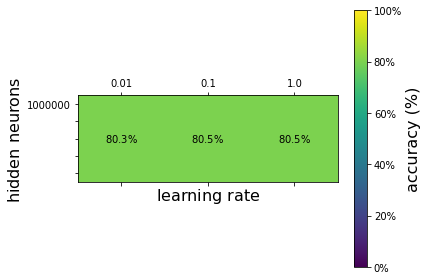

In [8]:
import argparse # handles arguments
import sys; sys.argv=['']; del sys # required to use parser in jupyter notebooks

# Training settings
parser = argparse.ArgumentParser(description='PyTorch SUSY Example')
parser.add_argument('--dataset_size', type=int, default=100000, metavar='DS',
                help='size of data set (default: 100000)')
parser.add_argument('--high_level_feats', type=bool, default=None, metavar='HLF',
                help='toggles high level features (default: None)')
parser.add_argument('--batch-size', type=int, default=100, metavar='N',
                help='input batch size for training (default: 64)')
parser.add_argument('--test-batch-size', type=int, default=1000, metavar='N',
                help='input batch size for testing (default: 1000)')
parser.add_argument('--epochs', type=int, default=25, metavar='N',
                help='number of epochs to train (default: 10)')
parser.add_argument('--lr', type=float, default=0.05, metavar='LR',
                help='learning rate (default: 0.02)')
parser.add_argument('--momentum', type=float, default=0.5, metavar='M',
                help='SGD momentum (default: 0.5)')
parser.add_argument('--no-cuda', action='store_true', default=False,
                help='disables CUDA training')
parser.add_argument('--seed', type=int, default=2, metavar='S',
                help='random seed (default: 1)')
parser.add_argument('--log-interval', type=int, default=10, metavar='N',
                help='how many batches to wait before logging training status')
args = parser.parse_args()

# set seed of random number generator
torch.manual_seed(args.seed)

grid_search(args)
